In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()

In [3]:
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [4]:
# remove duplicate words
# words = list(set(words))

In [5]:
chars =  ['.'] + sorted(list(set(''.join(words)))) 
stoi = {s: i for i, s in enumerate(chars)}
itos = {i: s for s, i in stoi.items()}

In [6]:
# dataset
block_size = 8
def build_dataset(words):
    X, Y = [], []
    for w in words:
        # print(w)
        context = [0]*block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '-->', itos[ix])
            context = context[1:]+[ix]
        
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [7]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # kaiming init
        self.bias = torch.randn(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
        

In [8]:
class BatchNorm1d:
    def __init__(self, dim, eps=1e-05, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffer for momentum update
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0,1)
            xmean = x.mean(dim, keepdim=True)
            xvar = x.var(dim, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        if self.training:
            self.running_mean = (1-self.momentum)*self.running_mean + self.momentum*xmean
            self.running_var = (1-self.momentum)*self.running_var + self.momentum*xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

In [9]:
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

In [10]:
class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))

    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out

    def parameters(self):
        return [self.weight]

In [11]:
class FlattenConsecutive:
    def __init__(self, n):
        self.n = n
    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T//self.n, C*self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
            
        self.out = x
        return self.out

    def parameters(self):
        return []
        

In [12]:
class Sequential:
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    

In [13]:
torch.manual_seed(42);

In [33]:
n_embd = 24
n_hidden = 128
vocab_size = len(itos)

model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False),BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False),BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False),BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

with torch.no_grad():
    model.layers[-1].weight *= 0.1

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True


76579


In [34]:
epochs = 200000
et = epochs/10
lr = 0.1
batch_size = 32

In [35]:
lossi=[]
stepi=[]
ep = 0

In [ ]:
%%time
# training
for i in range(epochs):
    # mini batch
    ix = torch.randint(0,Xtr.shape[0],(batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    #forward 
    logits = model(Xb)
        
    # loss
    loss = F.cross_entropy(logits, Yb)

    if i > 100000: lr = 0.01
        
    # backward
    for p in parameters:
        p.grad = None
    loss.backward()
    for p in parameters:
        p.data += -lr*p.grad
    
    # track stats 
    stepi.append(ep)
    lossi.append(loss.log10().item())
    ep+=1

    if i%et==0:
        print(f'{i}/{epochs}:  {loss.item():.4f}')
    # break

0/200000:  3.6093


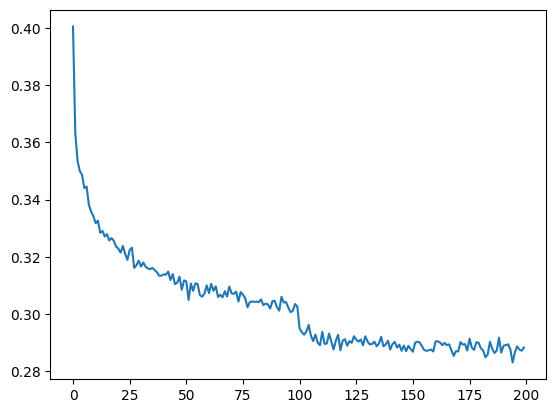

In [18]:
lossview = torch.tensor(lossi).view(-1, 1000).mean(1)
plt.plot(lossview)


In [19]:
for layer in model.layers:
    layer.training = False

In [20]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'dev': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(loss.item())

split_loss('train')
split_loss('dev')
split_loss('test')

1.921044945716858
2.026057243347168
2.0175225734710693


In [32]:
def generate(inp=''):
    if len(inp) < block_size:
        inp += '.'*(block_size - len(inp))
    output = []
    context = [stoi[f] for f in list(inp)]
    context = context[:block_size]
    while True:
        x = torch.tensor([context])
        logits = model(x)
        p = torch.softmax(logits, 1)
        ix = torch.multinomial(p, num_samples=1, replacement=True).item()
        output.append(itos[ix])
        context = context[1:]+[ix]
        if ix == 0:
            break
    return ''.join(output)

for i in range(15):
    out = generate()
    print(out)

jash.
elliss.
maymon.
avryu.
telenus.
marika.
nori.
karon.
grangela.
khandam.
merna.
mausten.
hastie.
anjmi.
nellah.
